## Вводная информация

Для исследования интернет магазином компьютерных игр предоставлена информация о продажа игр на разных платформах и в разных регионах за период 1980 - 2016 года. В данных присутствуют также рейтинги игр и ограничения по просмотрам.

Поставлена задача анализ данных по платформам игр, оценить средний срок жизни платформы, найти наиболее успешные платформы.
Необходимо составить портрет пользователей по разным регионам, указать на их общее поведение и различие.
Интересуют корреляции между рейтигами и объемами продаж.

На основе этих данных предлагалось сделать предпосылки и подготовить данные для прогноза на 2017 год.

Дополнительно были сформулированы гипотезы о одинаковости пользовательских рейтингах различных платформ и о различии пользовательских рейтингов различных жанров.

Ответы на все поставленные вопросы получены в ходе работы и обобщены в конце работы в выводах.



In [113]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
import pylab

warnings.simplefilter('ignore')

## Чтение, знакомство и приведение в порядок данных

In [114]:
games = pd.read_csv('/datasets/games.csv')
display(games)
games.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Данные прочитались сразу, с разделителями возиться не надо.

Всего данных 16715 строк. С первого взгляда можно сделать следующие предварительные выводы:
- у двух игр нет имени. Посмотрим, но скорее всего надо будет их выкинуть, в этих данных нет главного.
- год выпуска имеет много пропусков. Теоретически, его можно восстановить из интернета, но не хватает около 150 данных,это не ручная работа. Надо разбираться.
- оценки критиков, пользователей и ESRB , оценено чуть больше половины. Можно предположить, что оценки есть у наиболее популярных игр и их нет у тех, которые не вызвали интерес.

Для начала заменим заголовки столбцов и проверим на дубликаты всю таблицу

In [115]:
games.columns = games.columns.str.lower()
display(games.head())
display( 'Строка дубликатов',games.duplicated().unique())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


'Строка дубликатов'

array([False])

In [116]:
display(games.groupby('rating')['eu_sales'].sum().sort_values(ascending= False))

rating
E       710.25
M       483.97
T       427.03
E10+    188.52
AO        0.61
K-A       0.27
EC        0.11
RP        0.08
Name: eu_sales, dtype: float64

Дублированных строк нет. Найдем, какие проблемы с именами игр

In [117]:
display(games.loc[games['name'].isnull()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Восстановить имя невозможно, а без имени как-то не прилично. Удалим две строки.

In [118]:
games = games.drop(games.loc[games['name'].isnull()].index)
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Убрали две строки.

Посмотрим, что находится в данных типа object  и как их преобразовывать или использовать.

In [119]:
display(games['rating'].unique())
display(games['user_score'].unique())
display(games['platform'].unique())
display(games['genre'].unique())

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

По rating, platform, genre нет вопросов. Их не будем трогать, будем работать "как есть". А вот user_score в виде строковых данных представлены рейтинги типа float, а так же есть рейтинг tbd и nan. Как нам сказал Гугл, tbd  означает "еще нет рейтинга". Нет и нет, будет просто nan для однотипности.

Таким образом, в столбце user_score заменяем tbd  на nan,  а затем преобразуем во float

In [120]:
games.loc[games['user_score'] == 'tbd'] = np.nan
#display(games['user_score'].unique())

Будем менять типы переменных:

- user_score  - float
- year_of_release  - int
- critic_score  - int

In [121]:
games[['year_of_release','critic_score']] = games[['year_of_release','critic_score']].astype('Int64')
games['user_score'] = games['user_score'].astype('float')
display(games.head(10))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [122]:
games['all_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

# немногоо красоты

games = games [['name', 'platform','genre', 'year_of_release', 'critic_score','user_score','rating',
               'na_sales','eu_sales','jp_sales','other_sales','all_sales']]

display(games.head(10))
games.info()
display(games.query('rating == "K-A" or rating == "AO" or rating == "EC"'))

,name,platform,genre,year_of_release,critic_score,user_score,rating,na_sales,eu_sales,jp_sales,other_sales,all_sales
0,Wii Sports,Wii,Sports,2006,76,8.0,E,41.36,28.96,3.77,8.45,82.54
1,Super Mario Bros.,NES,Platform,1985,NaN,NaN,NaN,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,Wii,Racing,2008,82,8.3,E,15.68,12.76,3.79,3.29,35.52
3,Wii Sports Resort,Wii,Sports,2009,80,8.0,E,15.61,10.93,3.28,2.95,32.77
4,Pokemon Red/Pokemon Blue,GB,Role-Playing,1996,NaN,NaN,NaN,11.27,8.89,10.22,1.00,31.38
5,Tetris,GB,Puzzle,1989,NaN,NaN,NaN,23.20,2.26,4.22,0.58,30.26
6,New Super Mario Bros.,DS,Platform,2006,89,8.5,E,11.28,9.14,6.50,2.88,29.80
7,Wii Play,Wii,Misc,2006,58,6.6,E,13.96,9.18,2.93,2.84,28.91
8,New Super Mario Bros. Wii,Wii,Platform,2009,87,8.4,E,14.44,6.94,4.70,2.24,28.32
9,Duck Hunt,NES,Shooter,1984,NaN,NaN,NaN,26.93,0.63,0.28,0.47,28.31


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               14289 non-null object
platform           14289 non-null object
genre              14289 non-null object
year_of_release    14068 non-null Int64
critic_score       7055 non-null Int64
user_score         7590 non-null float64
rating             7575 non-null object
na_sales           14289 non-null float64
eu_sales           14289 non-null float64
jp_sales           14289 non-null float64
other_sales        14289 non-null float64
all_sales          14289 non-null float64
dtypes: Int64(2), float64(6), object(4)
memory usage: 1.7+ MB


,name,platform,genre,year_of_release,critic_score,user_score,rating,na_sales,eu_sales,jp_sales,other_sales,all_sales
656,Theme Hospital,PC,Strategy,1997,NaN,9.0,K-A,2.30,0.10,0.00,0.00,2.40
875,Grand Theft Auto: San Andreas,XB,Action,2005,93,8.6,AO,1.26,0.61,0.00,0.09,1.96
903,PaRappa The Rapper,PS,Misc,1996,92,7.4,K-A,0.26,0.16,1.46,0.03,1.91
6764,Dora the Explorer: Journey to the Purple Planet,PS2,Adventure,2005,NaN,7.0,EC,0.12,0.09,0.00,0.03,0.24
16681,Worms 2,PC,Strategy,1997,NaN,8.1,K-A,0.00,0.01,0.00,0.00,0.01


<div class="alert alert-info"> 
Последняя таблица немного вне логики развития темы, но она пришла сюда от работы с рейтигами. По данным за все время наблюдения видно, что рейтинги K-A, AO, EC имели всего пять программ

### Итоги по приведению данных.

Данные получены в более или менее пригодном для работы виде. Были удалены две строки с неизвестным названием игр, преобразованы данные, где логично будет целое значение, в тип int, строковые значения рейтинга во float  с заменой значения tbd на nan. Найдена сумма продаж по всем регионам.

После всего этого таблицу привели в более упорядоченный и красивый вид.

## Исследовательский анализ данных

### Анализ в разрезе времени


Для начала посмотрим, сколько игр выпускалось в разные годы, а заодно посчитаем объем выручки по ним

,count,sum
,all_sales,all_sales
year_of_release,,
1980,9,11.38
1981,46,35.68
1982,36,28.88
1983,17,16.80
1984,14,50.35
1985,14,53.95
1986,21,37.08
1987,16,21.70


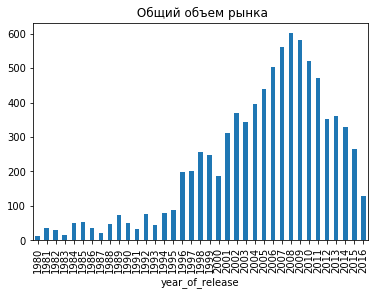

In [123]:
display(games.pivot_table(index = 'year_of_release',
                         values = 'all_sales',
                         aggfunc = ['count','sum']))

games.groupby('year_of_release')['all_sales'].sum().plot(kind= 'bar')
plt.title(' Общий объем рынка')
plt.show()

Получили таблицу продаж по годам с двумя столбцами данных: 

    - count  ассортимент продаваемых игр
    - sum    количество проданных копий в млн. штук
    
#### Итоги по времени
Из данных таблицы видно, что своего объема рынок достиг в 2008 году и за 8 лет упал в 4.68 раз по объему и в 2.18 раз по ассортименту. Получается, что ассортимент предлагаемых игр падает, но не так быстро, как общий объем продаж. Возможны два варианта развития:

- Средняя цена игры падает

- большое количество новых игр не пользуется спросом

### Анализ в разрезе платформ

Можно утверждать, что для современного состояния данные за 1980- и многие другие последующие годы не имеют значения для прикладного анализа сегодня. Здесь есть два момента:
   
   - меняются игровые платформы
   
   - меняется техника внутри платформ
   
   - игры устаревают морально и требуются все новые
    
Анализ через Гугл утверждает, что жизненный цикл большинства игр находится в пределах 5-7 лет. Если нам нужно прогнозировать 2017 год, то имеет смысл рассматривать только те платформы, которые используются в 2016 году. Изучим данные по этим платформам.


Сделаем группировку данных по годам и платформам. В качестве анализируемых данных выведем ассортимент и общий объем продаж.

In [124]:
games_platform = games.pivot_table(index = ['year_of_release','platform'],
                         values = 'all_sales',
                         aggfunc = ['count','sum','max'])
display(games_platform.head(20))
display(games_platform.tail(20))

count       sum       max
                         all_sales all_sales all_sales
year_of_release platform                              
1980            2600             9     11.38      4.31
1981            2600            46     35.68      4.50
1982            2600            36     28.88      7.81
1983            2600            11      5.84      1.31
                NES              6     10.96      3.20
1984            2600             1      0.27      0.27
                NES             13     50.08     28.31
1985            2600             1      0.45      0.45
                DS               1      0.02      0.02
                NES             11     53.44     40.24
                PC               1      0.04      0.04
1986            2600             2      0.67      0.37
                NES             19     36.41      6.50
1987            2600             6      1.94      0.65
                NES             10     19.76      4.38
1988            2600             2      0.74      0.51
                GB               1      1.43      1.43
                NES             11     45.01     17.28
                PC               1      0.03      0.03
1989            2600             2      0.63      0.48

count       sum       max
                         all_sales all_sales all_sales
year_of_release platform                              
2014            X360            61     33.77      4.28
                XOne            61     54.07      5.47
2015            3DS             77     27.21      3.32
                PC              48      8.49      1.28
                PS3             62     16.30      2.70
                PS4            136    118.86     14.63
                PSP              3      0.12      0.08
                PSV            104      5.95      0.41
                Wii              1      0.15      0.15
                WiiU            27     16.27      4.44
                X360            33     11.87      1.70
                XOne            77     59.92      7.39
2016            3DS             43     15.10      7.14
                PC              52      5.22      0.65
                PS3             32      3.16      0.73
                PS4            159     69.15      7.60
                PSV             84      4.24      0.30
                WiiU            11      4.30      1.03
                X360             8      1.22      0.38
                XOne            79     25.82      2.65

Сравнивая платформы за 2012- 2016 год и 1980 - 1990 видно, что используются разные платформы. Некоторые из них являются развитием предыдущих, а некоторых уже давно нет на рынке. Попробуем  найти актуальный период, который можно корректно использовать для анализа. Этим периодом можно будет считать:

- близкий к жизненному циклу программы 5-7 лет
- заметное изменение платформ на рынке.

Посмотрим платформы по успешности и выведем три таблицы: за все время, начиная с 2010 года и  живые платформы 2016 года

In [125]:
display(' Объем продаж по всем платформам за все время')

display(games.query('year_of_release > 1980').groupby('platform')['all_sales'].sum().sort_values(ascending= False))

display(' Объем продаж по всем платформам с 2010 года')

display(games.query('year_of_release > 2010').groupby('platform')['all_sales'].sum().sort_values(ascending= False))

display(' Объем продаж по всем платформам 2016 год')

display(games.query('year_of_release == 2016').groupby('platform')['all_sales'].sum().sort_values(ascending= False))

' Объем продаж по всем платформам за все время'

platform
PS2     1171.19
X360     948.74
PS3      921.09
Wii      791.91
PS       714.26
DS       655.36
PS4      314.00
PSP      273.11
GBA      263.70
GB       254.43
3DS      253.24
PC       252.25
NES      251.05
XB       236.38
N64      218.01
SNES     200.04
GC       185.68
XOne     158.77
WiiU      81.79
2600      75.10
PSV       53.50
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: all_sales, dtype: float64

' Объем продаж по всем платформам с 2010 года'

platform
PS3     441.53
X360    375.18
PS4     314.00
3DS     253.24
XOne    158.77
PC       97.11
WiiU     81.79
Wii      77.56
PSV      53.50
PSP      27.54
DS       24.73
PS2       0.40
Name: all_sales, dtype: float64

' Объем продаж по всем платформам 2016 год'

platform
PS4     69.15
XOne    25.82
3DS     15.10
PC       5.22
WiiU     4.30
PSV      4.24
PS3      3.16
X360     1.22
Name: all_sales, dtype: float64

Play Station во всех его модификациях - безусловный лидер. А две последних таблицы показывают, как умирали платформы с 2010 по 2016 года.

Немного подробнее объемы продаж по платформам за 2011-2016 года и отдельно 2016 год.

In [126]:
# Попробуем найти платформы с максимальными продажами за каждый год
display(' Объем продаж по всем платформам по годам')
display(games.pivot_table(index =['platform','year_of_release'],
                                  values = 'all_sales',
                                  aggfunc = ['count','sum']).query('year_of_release > 2010'))

display(' Объем продаж по всем платформам 2016 год')

display(games.pivot_table(index =['platform','year_of_release'],
                                  values = 'all_sales',
                                  aggfunc = ['count','sum']).query('year_of_release == 2016'))


' Объем продаж по всем платформам по годам'

count       sum
                         all_sales all_sales
platform year_of_release                    
3DS      2011                   91     60.53
         2012                   89     51.01
         2013                   87     56.32
         2014                   71     43.07
         2015                   77     27.21
         2016                   43     15.10
DS       2011                   91     13.48
         2012                   15     10.28
         2013                    3      0.97
PC       2011                  126     34.55
         2012                   61     23.22
         2013                   38     12.38
         2014                   46     13.25
         2015                   48      8.49
         2016                   52      5.22
PS2      2011                    6      0.40
PS3      2011                  192    154.14
         2012                  145    107.29
         2013                  125    113.24
         2014                  103     47.40
         2015                   62     16.30
         2016                   32      3.16
PS4      2013                   16     25.99
         2014                   75    100.00
         2015                  136    118.86
         2016                  159     69.15
PSP      2011                  134     16.72
         2012                  104      7.32
         2013                   54      3.14
         2014                   10      0.24
         2015                    3      0.12
PSV      2011                   18      4.63
         2012                   53     16.19
         2013                   63     10.59
         2014                  100     11.90
         2015                  104      5.95
         2016                   84      4.24
Wii      2011                   82     45.61
         2012                   25     21.08
         2013                    8      8.11
         2014                    3      2.61
         2015                    1      0.15
WiiU     2012                   32     17.56
         2013                   42     21.65
         2014                   30     22.01
         2015                   27     16.27
         2016                   11      4.30
X360     2011                  179    140.18
         2012                  105     99.57
         2013                   74     88.57
         2014                   61     33.77
         2015                   33     11.87
         2016                    8      1.22
XOne     2013                   19     18.96
         2014                   61     54.07
         2015                   77     59.92
         2016                   79     25.82

' Объем продаж по всем платформам 2016 год'

,,count,sum
,,all_sales,all_sales
platform,year_of_release,,
3DS,2016,43,15.10
PC,2016,52,5.22
PS3,2016,32,3.16
PS4,2016,159,69.15
PSV,2016,84,4.24
WiiU,2016,11,4.30
X360,2016,8,1.22
XOne,2016,79,25.82


Для выбора актуального периода построим графики продаж:

- по платформам с максимальными продажами за весь период наблюдения
- по платформам, живым в 2016 году за период 2010-2016 года

Для этого сделаем функцию, что бы не повторять код.

In [127]:
def sales_shedule(bottom_year, top_year, name_plat):
    games.query('platform == @name_plat & year_of_release >= @bottom_year & year_of_release <= @top_year').groupby('year_of_release')['all_sales'].sum().plot( kind='bar')
    plt.title('Объем продаж платформы '+name_plat)
    plt.show()
    
#x = 'PS2'
#sales_shedule(1980,2016,x)

Посмотрим наиболее удачные платформы за весь период наблюдения. Оценим их жизненный цикл 

'Графики продаж наиболее успешных платформ за весь период наблюдения'

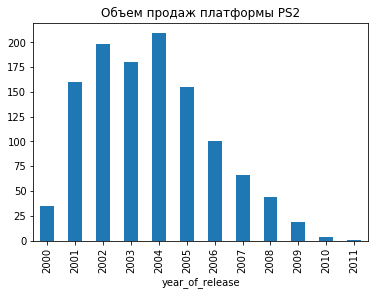

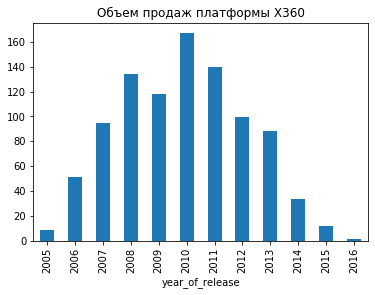

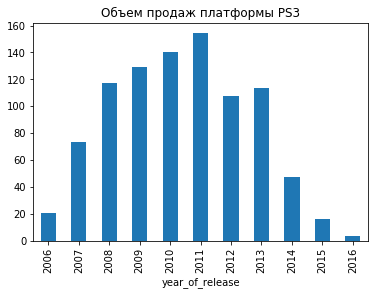

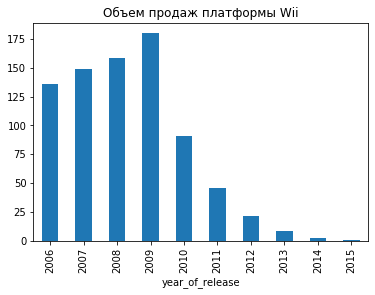

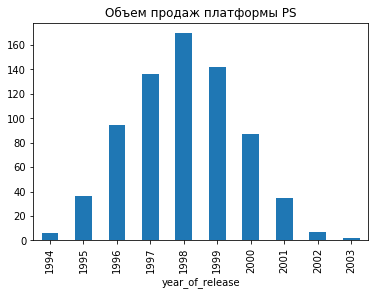

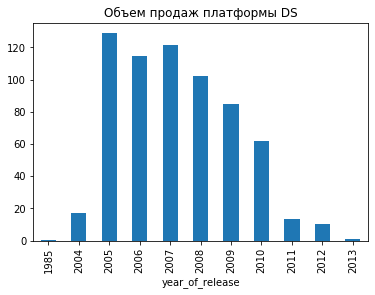

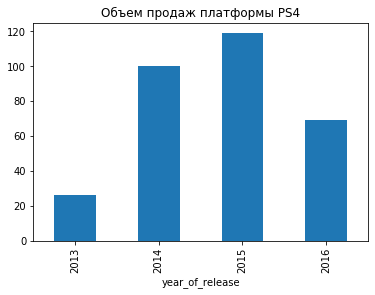

In [128]:
sked = ['PS2','X360','PS3','Wii','PS','DS','PS4',]
list_plat = pd.Series(sked)

display('Графики продаж наиболее успешных платформ за весь период наблюдения')
for plat in list_plat:
    sales_shedule(1980,2016,plat)

И платформы, живые в 2016 году  


' Графики продаж платформ, которые работают в 2016 году'

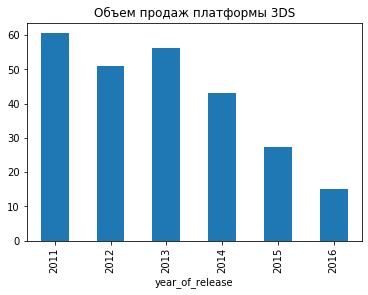

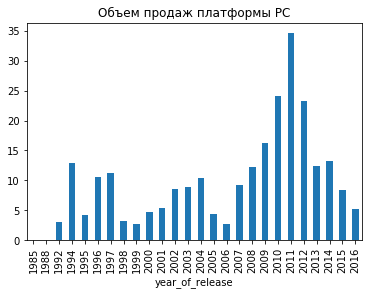

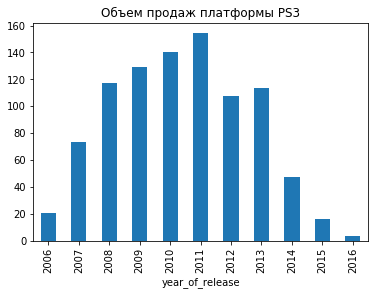

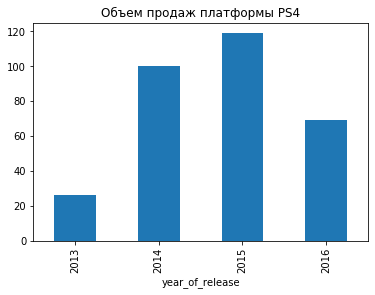

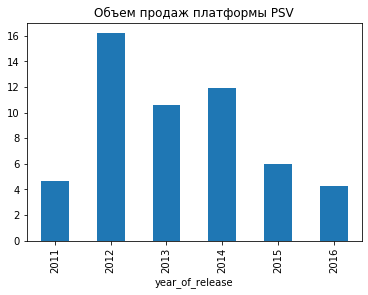

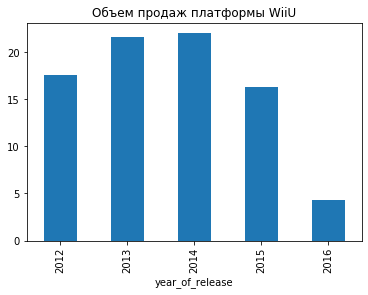

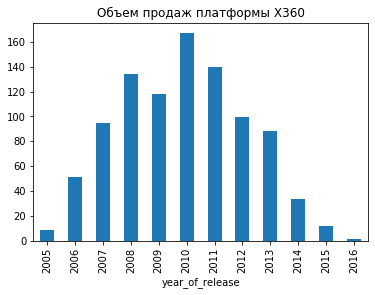

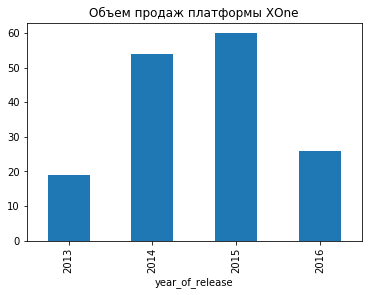

In [129]:
sked = ['3DS','PC','PS3','PS4','PSV','WiiU','X360','XOne']
list_plat = pd.Series(sked)

display(' Графики продаж платформ, которые работают в 2016 году')

for plat in list_plat:
    sales_shedule(1980,2016,plat)

#### Итоги анализа в разрезе платформ

Как видно из полученных данных, за период наблюдения на рынок выходили много разных платформ. Первая десятка из них с суммарными объемами продаж приведена ниже :

In [130]:
display('Десять самых успешниых платформ за весь период ')
display(games.query('year_of_release > 1980').groupby('platform')['all_sales'].sum().sort_values(ascending= False).head(10))

'Десять самых успешниых платформ за весь период '

platform
PS2     1171.19
X360     948.74
PS3      921.09
Wii      791.91
PS       714.26
DS       655.36
PS4      314.00
PSP      273.11
GBA      263.70
GB       254.43
Name: all_sales, dtype: float64

По шести самым успешным был проведен анализ жизненного цикла платформы. По графикам видно, что только одна из платформ, DC, смогла удержаться на рынке больше 11 лет. Срок жизни успешных платформ от первого выхода на рынок до полного исчезновения составляет 10-11 лет.

Я предполагаю взять для дальнейшей работы половину жизненного цикла платформ, то есть рассматривать данные за пять лет, за период 2011 - 2016 года.

Для анализа имеет смысл определиться и с платформами, которые имеет смысл принимать во внимание. На 2016 продажи осуществляются по 8 платформам. Выведем объем продаж по ним и посмотрим на него в совокупности с графиками:

In [131]:
display(' Объем реализации по платформам 2016 год')
display(games.pivot_table(index =['platform','year_of_release'],
                                  values = 'all_sales',
                                  aggfunc = ['count','sum']).query('year_of_release == 2016'))


' Объем реализации по платформам 2016 год'

,,count,sum
,,all_sales,all_sales
platform,year_of_release,,
3DS,2016,43,15.10
PC,2016,52,5.22
PS3,2016,32,3.16
PS4,2016,159,69.15
PSV,2016,84,4.24
WiiU,2016,11,4.30
X360,2016,8,1.22
XOne,2016,79,25.82


Платформа X360 согласно графику находится в конце жизненного цикла, ей 11 лет. Реализует всего 8 игр и развиваться дальше не будет. Если необходимо, ее можно будет удалить из расчетов.

PSV и WiiU имеют примерно одинаковые характеристики. Они практически одновременно вышли на рынок, сравнительно молоды, им 5 лет, но их объемы продаж падают. Я думаю, их нельзя исключать из рассмотрения, они еще будут бороться за рынок.

А вот PS3 благополучно умирает и можно предположить, что все основные клиенты перейдут в распоряжение более моллодого и современного PS4.

Остальные платформы сравнительно молоды и то, что на графиках мы видим падение объема продаж, это общая тенденция рынка.

Таким образом, для прогнозных расчетов я хочу рассматривать следующий список платформ:

3DS , PC , PS4 , PSV ,WiiU , XOne

Сделаем таблицу для анализа. Вид таблицы: год, группировка по платформам, сумма по платформам по всем регионам

In [132]:
carrent_year = 2010
games_plat = games.query('year_of_release >= @carrent_year').pivot_table(index = ['year_of_release','platform'],
                         values = 'all_sales', 
                         aggfunc = 'sum').reset_index()

games_year = games.query('year_of_release >= @carrent_year').pivot_table(index = ['year_of_release'],
                         values = 'all_sales',
                         aggfunc = 'sum').reset_index()
games_plat['market_share'] = 0.0
#display('Объем реализации по платформам по годам')
#display(games_plat.tail(30))
#display('Объем рынка по годам')
#display(games_year)

Дополним данные по каждому году долю на рынке каждой платформы

In [133]:
for i in games_year['year_of_release']:
    volume_market = games_year['all_sales'].loc[games_year['year_of_release'] == i].values[0]
    games_plat['market_share'].loc[games_plat['year_of_release'] == i] = games_plat['all_sales'].loc[games_plat['year_of_release'] == i] / volume_market
    
#display(games_plat.tail(40))

Для вывода графиков сделаем функцию, аналогичную вышеиспользованной

' Графики долей рынка платформ, которые работают в 2016 году в 2010-2016 годах'

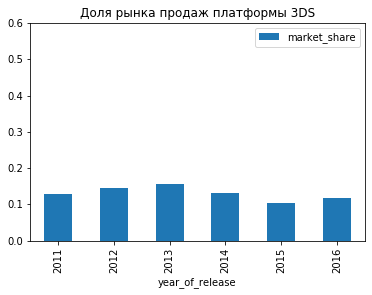

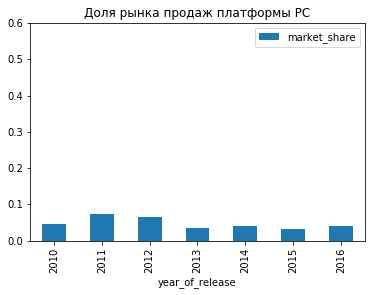

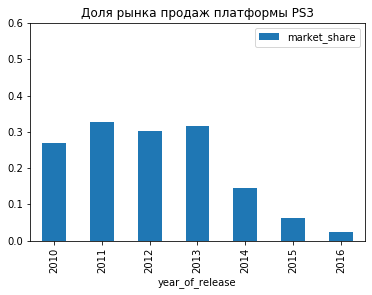

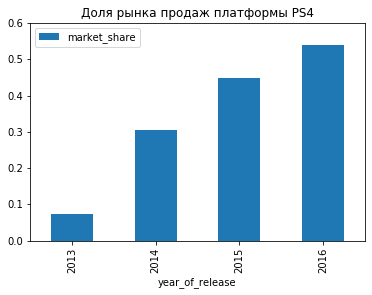

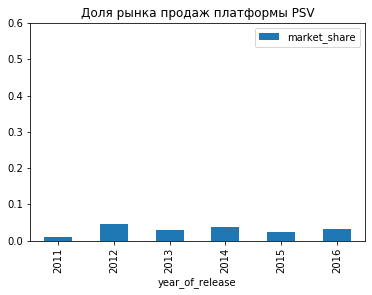

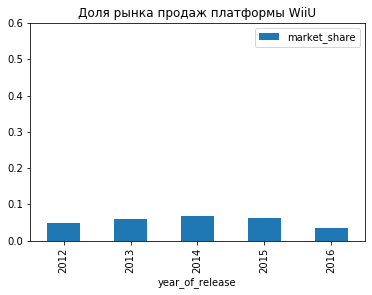

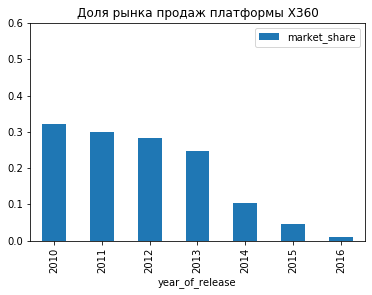

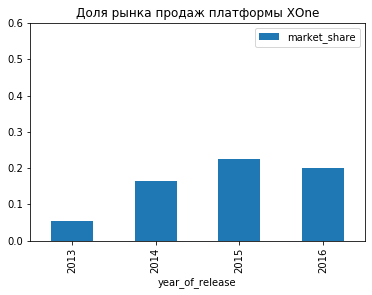

In [134]:
def sales_market(bottom_year, top_year, name_plat):
    out = games_plat.query('platform == @name_plat & year_of_release >= @bottom_year & year_of_release <= @top_year')
    out.plot('year_of_release','market_share', kind = 'bar' )
    plt.title('Доля рынка продаж платформы '+name_plat)
    plt.axis(ymax = 0.6)
    plt.show()
    #display(out)
    

display(' Графики долей рынка платформ, которые работают в 2016 году в 2010-2016 годах')

for plat in list_plat:
    sales_market(2010,2016,plat)

#### Итоги: лидеры роста

На графиках хоршо видно то, о чем мы говорили выше. Безусловным лидером является платформа PS4: запустившись в 2013 году она к 2016 году имеет более половины рынка, показывая резкий рост.Также растет, с небольшой потерей в 2016 году, платформа XOne. Ее доля с 2013 года дорасла до 20%. За этими двумя лидерами уверенно держитсся 3DS с долей на уровне 12-15%. 

Доли рынка PS3 и X360  стремительно падают.


#### Ящик с усами

Мы уже рассматривали данные сумарных продаж по каждой из платформ за все время, глянем разброс на "ящике с усами". Также, для удобства анализа, распечатем все платформы с их реализациями.

In [135]:
games = games.query('year_of_release > 2010')
#display(games['year_of_release'].unique())

' Объем продаж по всем платформам за все время'

platform
PS3     441.53
X360    375.18
PS4     314.00
3DS     253.24
XOne    158.77
PC       97.11
WiiU     81.79
Wii      77.56
PSV      53.50
PSP      27.54
DS       24.73
PS2       0.40
Name: all_sales, dtype: float64

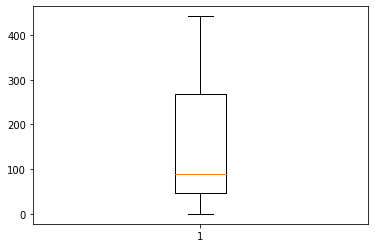

In [136]:
display(' Объем продаж по всем платформам за все время')

display(games.groupby('platform')['all_sales'].sum().sort_values(ascending= False))

plt.boxplot(games.groupby('platform')['all_sales'].sum());

На графике хорошо видно, что средний объем продаж в актуальном периоде по всем платформам лежит на уровне 80 млн. долларов. Все квартили довольно плотно расположены: третий квартиль на уровне 250 млн. долларов, четвертый ориентировочно около 450 млн. долларов. Вниз ящик растянут  почти до ноля. Все продажи лежат плотно, в пределах четырех квартилей, выбросов на графике не видно. По форме ящика можно говорить, что график распределения продаж будет сильно растянут вправо.

Посмотрим аналогичные ящики по платформам




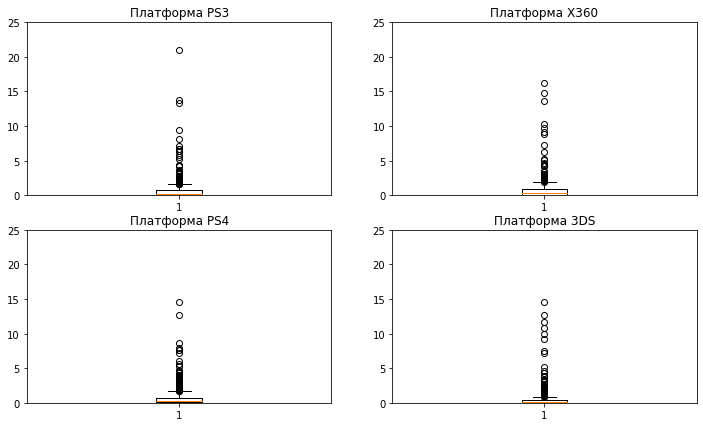

In [137]:
plt.figure(figsize=(12, 7))


plt.subplot(2,2,1)
plt.axis(ymax = 25)
plt.title('Платформа PS3')
plt.boxplot(games.query('platform == "PS3"')['all_sales'])



plt.subplot(2,2,2)
plt.axis(ymax = 25)
plt.title('Платформа X360')
plt.boxplot(games.query('platform == "X360"')['all_sales'])

plt.subplot(2,2,3)
plt.axis(ymax = 25)
plt.title('Платформа PS4')
plt.boxplot(games.query('platform == "PS4"')['all_sales'])


plt.subplot(2,2,4)
plt.axis(ymax = 25)
plt.title('Платформа 3DS')
plt.boxplot(games.query('platform == "3DS"')['all_sales'])

plt.show()

По каждой из платформ картина почти похожая. Основная масса продаж, с первого по четвертый квартиль, лежит где-то внизу. И есть некоторое количество программ, которые "выстрелили"

(0, 3.5)

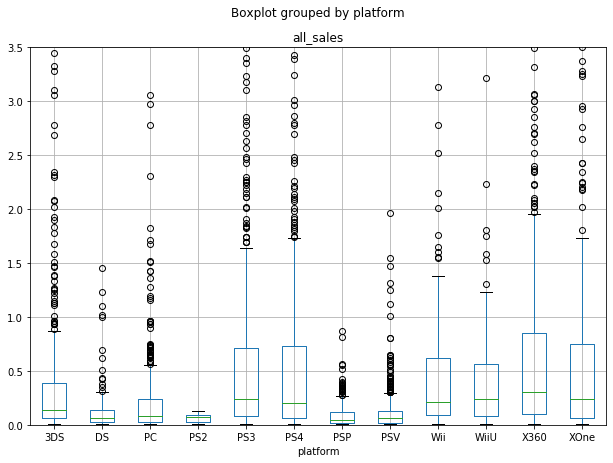

In [138]:
# КОД РЕВЬЮЕРА

games.boxplot('all_sales', by='platform', figsize=(10,7))
plt.ylim(0,3.5)

### Влияние отзывов пользователей и критиков на продажи


Для этого анализа возьмем платформу X360. Из лидеров на 2016 год платформ она наиболее древняя и имеет большой ассортимент.

Отберем все, что было создано на этой платформе.

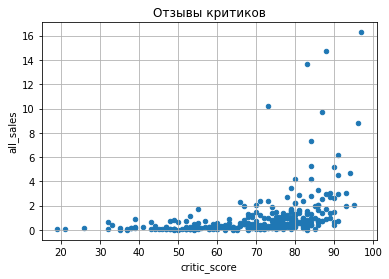

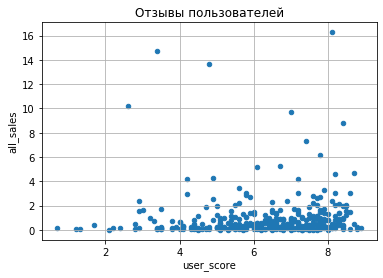

'Отзывы критиков/продажи'

0.3900051055540925

'Отзывы пользователей/продажи'

0.0389181707291026

In [139]:
#display(games.query('platform == "X360" ').sort_values('year_of_release'))

games.query('platform == "X360" ').plot(x = 'critic_score',
                                       y = 'all_sales',
                                       kind = 'scatter',
                                       grid = True)
plt.title('Отзывы критиков')
games.query('platform == "X360" ').plot(x = 'user_score',
                                       y = 'all_sales',
                                       kind = 'scatter',
                                       grid = True)
plt.title('Отзывы пользователей')
plt.show()


display('Отзывы критиков/продажи')
dt = games.query('platform == "X360" ')                    # непонятно почему, но функция .corr не считает корреляцию
dt['critic_score'] = dt['critic_score'].astype('float')    # корреляцию между int и float  
display(dt['all_sales'].corr(dt['critic_score']))          # пришлось преобразовывать тип

display('Отзывы пользователей/продажи')
display(games.query('platform == "X360" ')['user_score'].corr(games.query('platform == "X360" ')['all_sales']))





Посмотрим такие же кореляции просто по всему массиву данных

In [140]:
display('Отзывы критиков/продажи')
#dt = games.query('platform == "X360" ')                    # непонятно почему, но функция .corr не считает корреляцию
dt['critic_score'] = dt['critic_score'].astype('float')    # корреляцию между int и float  
display(dt['all_sales'].corr(dt['critic_score']))          # пришлось преобразовывать тип

display('Отзывы пользователей/продажи')
display(games['user_score'].corr(games['all_sales']))


'Отзывы критиков/продажи'

0.3900051055540925

'Отзывы пользователей/продажи'

0.03163612772559288

#### Вывод: критики и пользователи

На основании данных можно сделать вывод, что для платформы X360 разброс мнений пользователей гораздо сильнее разбросан, чем критиков. И можно однозначно сказать, что мнение критиков гораздо сильнее коррелирует с объемом продаж

Вообще по всем платформам наблюдается аналогичная тенденция

### Анализ данных по жанрам

Построим сразу гистограмму распределния по жанрам за весь период наблюдения


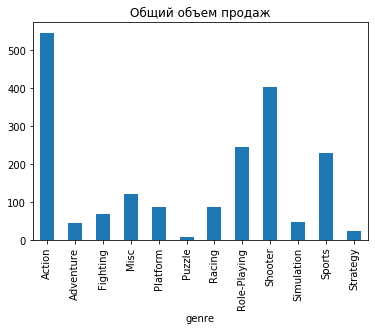

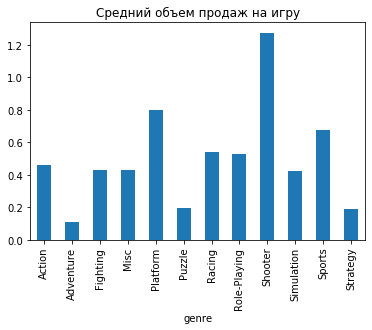

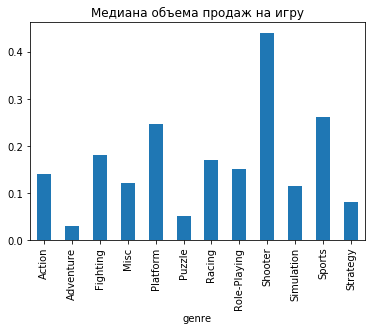

In [141]:
games.groupby('genre')['all_sales'].sum().plot(kind = 'bar')
plt.title('Общий объем продаж')
plt.show()
games.groupby('genre')['all_sales'].mean().plot(kind = 'bar')
plt.title('Средний объем продаж на игру')
plt.show()
games.groupby('genre')['all_sales'].median().plot(kind = 'bar')
plt.title('Медиана объема продаж на игру')
plt.show()

#### Вывод по жанрам

Явный лидер по продажам - жанр "Action". Наименьшим спросом пользуются "Adventure', 'Puzzle', 'Strategy'.

Соотношение медианы и среднего повторяет то, что мы видим по "ящику с усами": значительный объем продаж делается на выбросах, на наиболее удачных нескольких играх.

## Портрет пользователя

Изучим в разрезе регионов популярность платформ и жанров, а также посморим на влияние рейтингов ESRB

' Первые пять платформ'

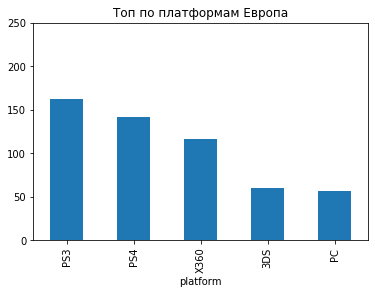

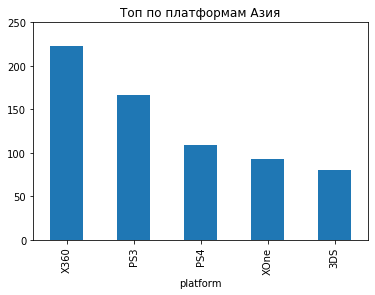

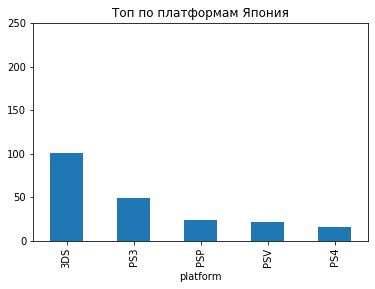

In [142]:
#display(games.groupby('platform')['eu_sales'].sum().sort_values(ascending= False).head())
display(' Первые пять платформ')
games.groupby('platform')['eu_sales'].sum().sort_values(ascending= False).head().plot(kind = 'bar')
plt.axis(ymax = 250)
plt.title('Топ по платформам Европа')
plt.show()
games.groupby('platform')['na_sales'].sum().sort_values(ascending= False).head().plot(kind = 'bar')
plt.axis(ymax = 250)
plt.title('Топ по платформам Азия')
plt.show()
games.groupby('platform')['jp_sales'].sum().sort_values(ascending= False).head().plot(kind = 'bar')
plt.axis(ymax = 250)
plt.title('Топ по платформам Япония')
plt.show()

' Первые пять жанров'

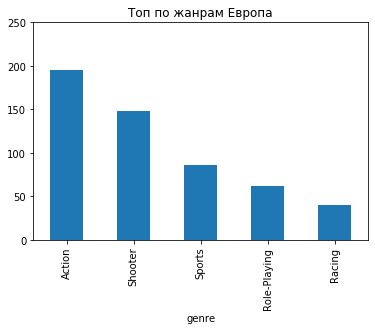

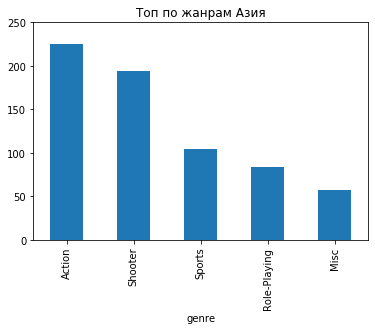

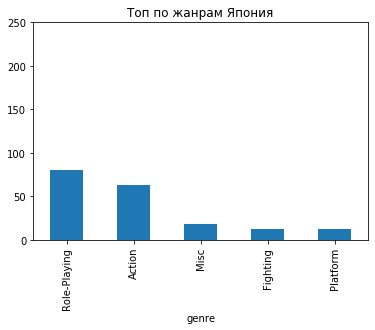

In [143]:
display(' Первые пять жанров')

games.groupby('genre')['eu_sales'].sum().sort_values(ascending= False).head().plot(kind = 'bar')
plt.axis(ymax = 250)
plt.title('Топ по жанрам Европа')
plt.show()
games.groupby('genre')['na_sales'].sum().sort_values(ascending= False).head().plot(kind = 'bar')
plt.axis(ymax = 250)
plt.title('Топ по жанрам Азия')
plt.show()
games.groupby('genre')['jp_sales'].sum().sort_values(ascending= False).head().plot(kind = 'bar')
plt.axis(ymax = 250)
plt.title('Топ по жанрам Япония')
plt.show()

In [144]:
display(games.groupby('rating')['eu_sales'].sum().sort_values(ascending= False))

rating
M       250.23
E       135.30
T        81.15
E10+     72.89
RP        0.03
Name: eu_sales, dtype: float64

По суммам продаж у нас есть только данные по пяти видам рейтинга. А что же с другими рейтингами?

 'K-A', 'AO', 'EC', 

In [145]:
display(games.query('rating == "K-A" or rating == "AO" or rating == "EC"'))

,name,platform,genre,year_of_release,critic_score,user_score,rating,na_sales,eu_sales,jp_sales,other_sales,all_sales


In [146]:
games['rating'].fillna("No rating", inplace = True)    # заменим пустые значения рейтингов на No rating

' Графики по ограничениям по рейтингу'

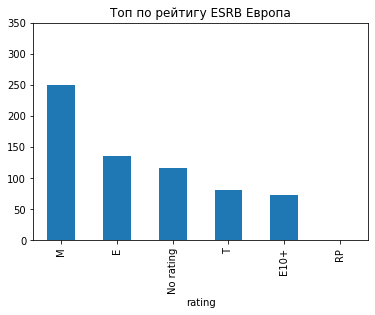

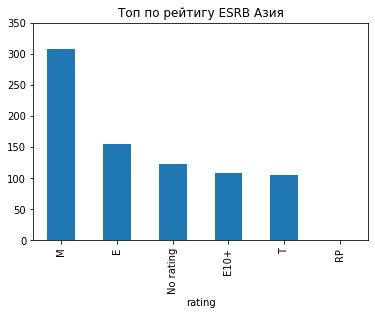

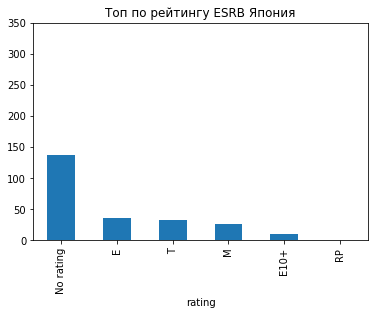

In [147]:
display(' Графики по ограничениям по рейтингу')
games.groupby('rating')['eu_sales'].sum().sort_values(ascending= False).plot(kind = 'bar')
plt.axis(ymax = 350)
plt.title('Топ по рейтигу ESRB Европа')
plt.show()
games.groupby('rating')['na_sales'].sum().sort_values(ascending= False).plot(kind = 'bar')
plt.axis(ymax = 350)
plt.title('Топ по рейтигу ESRB Азия')
plt.show()
games.groupby('rating')['jp_sales'].sum().sort_values(ascending= False).plot(kind = 'bar')
plt.axis(ymax = 350)
plt.title('Топ по рейтингу ESRB Япония')
plt.show()

### Выводы: портрет пользователя, разные регионы

Мы посмотрели оазличия в поведении пользователей в Европе, Азии и Японии в предпочтениях по платформам, жанрам и ограничениям.

Пользователи Европы и Азии предпочитают одинаковые платформы с небольшими различиями. Жители Японии препочитают платформы, созданный у них в стране.

В предпочтениях по жанрам европейцы и азиаты очень похожи, у японцев на первом месте стоит ролевая игра, а остальное как у других регионов

По ограничениям никаких неожиданностей по всем регионам: чем меньше ограничений, тем выше продажи. Однако в стороне опять страна восходящего солнца: продажа игр без рейтига в Японии превосходит все другие продажи.




## Проверка гипотез

### Гипотеза о совпадении рейтинов платформ

Сформулируем гипотезы. Нулевая гипотеза: средние пользовательсткие рейтинги платформ XOne и PC одинаковые

Альтенативная гипотеза:средние пользовательсткие рейтинги платформ XOne и PC не  равны

Проверяем нулевую гипотезу


In [148]:
alfa = 0.05
results = st.ttest_ind(games.query('platform == "XOne"')['user_score'],
                       games.query('platform == "PC"')['user_score'],
                      nan_policy = 'omit')
display(results.pvalue)
if results.pvalue < alfa:
    display('Отвергаем нулевую гипотезу')
else:
    display( ' Не получилось отвергнуть нулевую гипотезу')


0.6267602271422317

' Не получилось отвергнуть нулевую гипотезу'

### Гипотеза о рейтингах жанров 

Сформулируем гипотезы. Нулевая гипотеза: Средние пользовательские рейтинги Action и Sports равны.

Альтенативная гипотеза: средние рейтинги Action и Sports не равны

Проверим альтернативную гипотезу

In [149]:
alfa = 0.05
results = st.ttest_ind(games.query('genre == "Sports"')['user_score'],
                       games.query('genre == "Action"')['user_score'],
                      nan_policy = 'omit')
display(results.pvalue)
if results.pvalue < alfa:
    display('Отвергаем нулевую гипотезу')
else:
    display( ' Не получилось отвергнуть нулевую гипотезу')


5.1974550252128566e-24

'Отвергаем нулевую гипотезу'

### Вывод по гипотезам
В результате проверки гипотез делаем вывод:
- гипотеза средние пользовательсткие рейтинги платформ XOne и PC одинаковые  верна
- гипотеза средние пользовательские рейтинги Action и Sports разные  верна

## Общие выводы по анализу

Для анализа был представлен массив данных по продажам электронных игр с 1980 по 2016 годы с данными по объемам продаж по регионам, рейтингами и ограничениями. Для работы был поставлен ряд вопросов, на которые были дыны ответы в ходе проведения работы. В данном разделе сведем все ответы на поставленные вопросы.

Анализ рынка показал, что до 2008 года продажи электронных игр быстро росли, после 2008 года стали быстро падать и к 2016 году упали в 4,16 раз.

Был проведен анализ данных по объемам продаж по платформам. Был сделан вывод, что средний цикл жизни платформы составляет 10-11 лет. За этот период платформа выходит на рынок, достигает своего максимума продаж к середине срока и затем падает практически до ноля. В принципе, в этом нет ничего неожиданного, раз в 10 лет кардинально меняются требования к вычислительной технике и качеству и скорости игр.

Абсолютным лидером является плтформа PS. Мало того, что PS2 является самым успешниым за все время наблюдения, но ее клоны все время находятся на передовых позициях. 

Для анализа и попытки прогноза развития выл выбран актуальный период 2010-2011 года. Это примерно половина жизненного цикла платформы, и на этом периоде виден и рост и угазание платформ. Так как рынок падает, для оценки платформ були использованы не абсолютные показатели продаж, а доля каждой платформы на рынке.

Безусловным лидером является платформа PS4: запустившись в 2013 году она к 2016 году имеет более половины рынка, показывая резкий рост.Также растет, с небольшой потерей в 2016 году, платформа XOne. Ее доля с 2013 года дорасла до 20%. За этими двумя лидерами уверенно держитсся 3DS с долей на уровне 12-15%.
Доли рынка PS3 и X360 стремительно падают.

Поквартильный анализ показал, что основная масса программ по объемам продаж находится в "ящике", "Усы" близки к ящику. Это означает, что продажи осноной массы платформ находятся близко друг к другу. На этом же графике видны "выбросы" наиболее успешных программ. Эти же данные можно наблюдать в таблице.

На основании анализа отзывов критиков и пользователей, можно говорить о высокой корреляции между оценками критиков и объемами продаж. По разбросам видно, что мнения критиков менее разнообразны и коррелируют с высокими показателями за объемами продаж. Мнения пользователей имею большие разбросы, разнообразие, и их корреляция с объемами продаж в два раза меньше, чем корреляция критиков. Делать вывод, что мнение критиков поднимает объем продаж или наоборот, что чем выше объем продаж, тем более признанной является игра, я не решаюсь.

Были исследованы региональные особенности рынка игр по трем регионам: Европа, Азия и Япония. Был сделан анализ по предпочтительным платформам и поведению пользователей по жанрам и рейтингу ESRB. Можно утверждать, что пользователи из Японии болеe тяготеют к своим платформам, играя на 3DS,PS4,PSS, а поведение европейцев и азиатов  одинаковы, они играют на PS3, PS4, X360. 
Жанровые предпочтения в Европе и Азии очень близки, здесь предпочитают 'Action', 'Shooter', 'Sports', а жители Японии 'Role- Playing', 'Action', 'Misc'. 
В отношении рейтига ESRB  жители всех трех регионов практически не сильно отличаются.

Дополнительно была проверена и подтверждена гипотеза, что пользовательские рейтинги платформ XOne одинаковы
Проверена и подтверждена гипотеза, что  средние пользовательские рейтинги Action и Sports разные 